In [1]:
import numpy as np
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt

np.random.seed(1123)

In [2]:
# Monte Carlo Simulation
dice_payoff = [0.5, 1.05, 1.5]
dice_probs = [1/6, 4/6, 1/6]
n_trials = 10_000
n_rolls = 300
mc = np.random.choice(dice_payoff, (n_trials, n_rolls), p=dice_probs)

In [3]:
arithmetic_mean = np.mean(mc, axis=1)
arithmetic_center  = np.mean(arithmetic_mean)
print(f"Arithmetic expected value: {arithmetic_center}")

geometric_mean = gmean(mc, axis=1)
geom_center  = gmean(geometric_mean)
print(f"Geometric expected value: {geom_center}")


Arithmetic expected value: 1.0332696
Geometric expected value: 0.9846144597539275


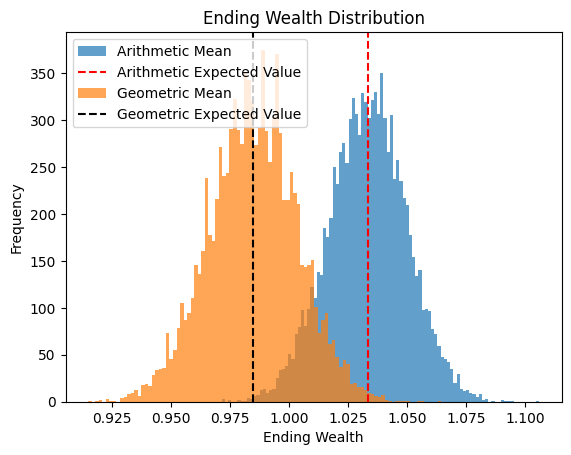

In [4]:
fig, ax = plt.subplots()
ax.hist(arithmetic_mean, bins=100, alpha=0.7, label='Arithmetic Mean')
plt.axvline(x=arithmetic_center, color='red', linestyle='--', label='Arithmetic Expected Value')
ax.hist(geometric_mean, bins=100, alpha=0.7, label='Geometric Mean')
plt.axvline(x=geom_center, color='black', linestyle='--', label='Geometric Expected Value')
ax.set_xlabel('Ending Wealth')
ax.set_ylabel('Frequency')
ax.set_title('Ending Wealth Distribution')
ax.plot()
ax.legend()

In [5]:
print(f"Expected $1 wealth after {n_rolls} rolls: ${geom_center**n_rolls:.2f} or a {(geom_center**n_rolls/1)**(1/n_rolls)-1:.2%} geometric compound growth rate")
print(f"Expected $1 wealth after {n_rolls} rolls: ${arithmetic_center**n_rolls:.2f} or a {(arithmetic_center**n_rolls/1)**(1/n_rolls)-1:.2%} arithmetic compound growth rate")

Expected $1 wealth after 300 rolls: $0.01 or a -1.54% geometric compound growth rate
Expected $1 wealth after 300 rolls: $18369.43 or a 3.33% arithmetic compound growth rate


## Kelly Criterion

In [66]:
# using a 40% bet and 60% cash
a = geom_center*0.4+0.6
b = arithmetic_center*0.4+0.6

print(f"Geometric Average: {(((a**n_rolls))/1)**(1/n_rolls)-1:.2%}") #incorrect should be 0.62%
print(f"Arithmetic Average: {((b**n_rolls)/1)**(1/n_rolls)-1:.2%}")

Geometric Average: -0.62%
Arithmetic Average: 1.33%
